In [ ]:
!pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.4/195.4 kB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 263.5/263.5 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 6.2 MB/s eta 0:00:00


Importing Libraries

In [ ]:
import numpy as np
from tqdm import tqdm
import wandb
import matplotlib.pyplot as plt
import copy
from keras.datasets import fashion_mnist
from keras.datasets import mnist
import seaborn as sns

# Question 1 (2 Marks)
Download the fashion-MNIST dataset and plot 1 sample image for each class as shown in the grid below. Use ```from keras.datasets import fashion_mnist``` for getting the fashion mnist dataset.

In [ ]:
(x_train, y_train), (x_test, y_test)=fashion_mnist.load_data()

4422102/4422102 [==============================] - 0s 0us/step


In [ ]:
def all_classes():
    i=0
    arr=[]
    j=0
    class_names=['T-shirt/Top','Trouser','Pullover','Dress','Coat',   #classes
                  'Sandal','Shirt','Sneaker','Bag','Ankle boot']

    class_remaning=list(range(0,10))
    while len(class_remaning):
        if y_train[i] ==j :
            class_remaning.remove(j)
            plt.figure(figsize=(5, 5)) #will plot 10x10 inches figure
            plt.yticks([])
            plt.imshow(x_train[i],cmap='gray')
            plt.grid(False)
            plt.xticks([]) #remove x axis tick lines
            plt.title('Class'+str(class_names[j]))
            plt.show()
            arr.append(np.expand_dims(x_train[i],axis=-1))
            j+=1
        i+=1
    return arr, class_names

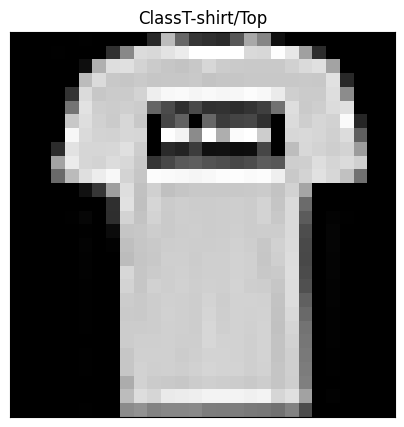

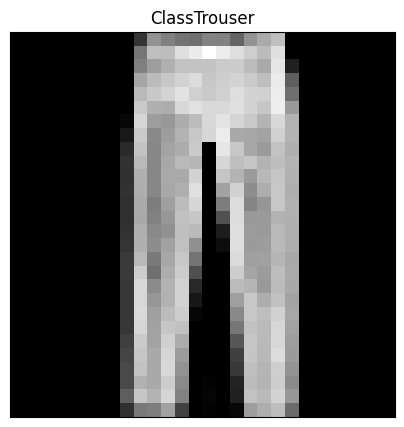

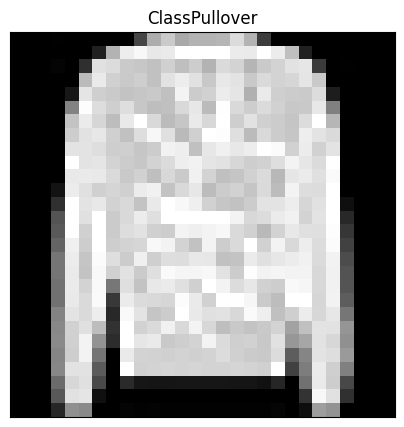

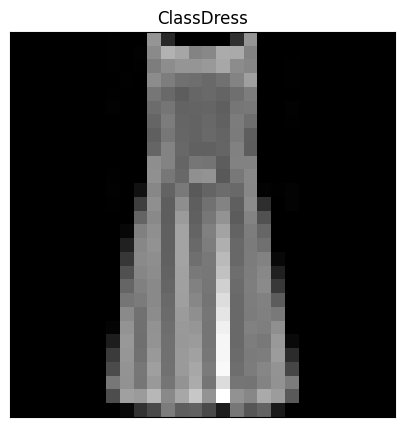

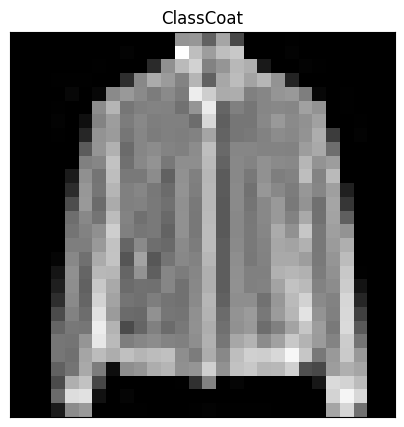

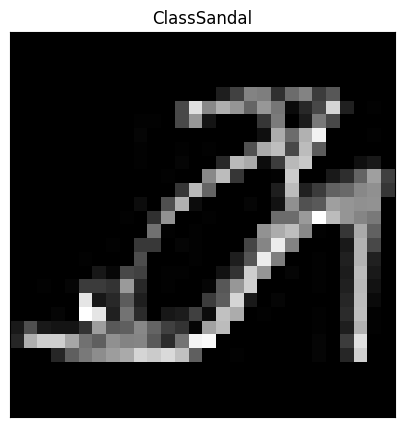

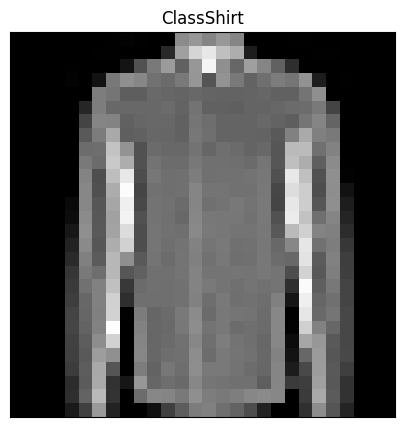

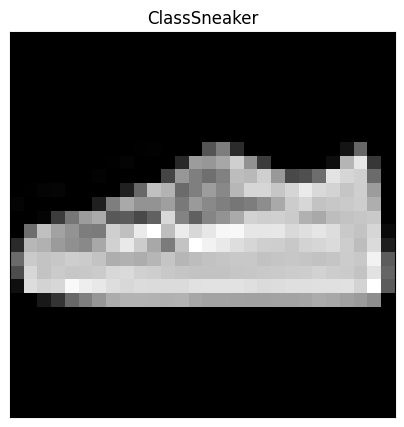

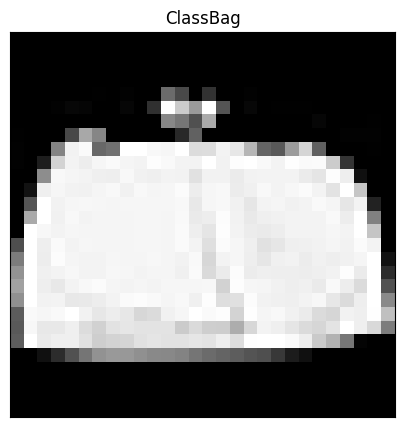

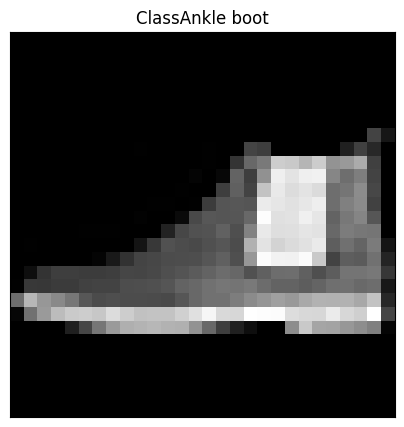

In [ ]:
image_array , label_array = all_classes()

In [ ]:
wandb.login(key='5157ae11e5d243722bc57912a56718dc8ef2f734')

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
wandb.init(project="CS23M013_DL_A1",id="question 1")
i=0
while i<10:
    images = wandb.Image(image_array[i], caption=label_array[i])
    wandb.log({"Fashion_MNIST": images})
    i+=1
wandb.run.finish()

wandb: Currently logged in as: cs23m013. Use `wandb login --relogin` to force relogin


# Question 2 (10 Marks)
Implement a feedforward neural network which takes images from the fashion-mnist data as input and outputs a probability distribution over the 10 classes.

Your code should be flexible such that it is easy to change the number of hidden layers and the number of neurons in each hidden layer.

Creating all activation functions

In [ ]:
def activation_functions(activation):

    def sigmoid(x): #sigmoid function
        return 1/(1 + np.exp(-x))

    def softmax(x): #softmax function
        m=x-np.max(x,axis=0)
        n=np.exp(m)
        return n/np.sum(n,axis=0)

    def ReLU(x):   #ReLU activation function
        return np.maximum(0, x)


    def identity(x):#identity function
        return x

    #choices for all the activation functions
    if activation == 'sigmoid':
      activation_function = sigmoid
    elif activation == 'softmax':
      activation_function = softmax
    elif activation == 'tanh':
      activation_function = np.tanh
    elif activation == 'ReLU':
      activation_function = ReLU
    elif activation == 'identity':
      activation_function = identity
    else:
      activation_function = ReLU

    return activation_function

Defining Derivatives of all Activation functions

In [ ]:
def activation_diff(activation):


    def sigmoid_diff(x): #derivative of sigmoid
        ex_p=(1 + np.exp(-x))
        minus_ex_p=(1 + np.exp(x))
        sig= np.where(x >= 0, 1 / ex_p, np.exp(x) / minus_ex_p)
        sig= sig * ( 1-sig)
        return sig


    def softmax_diff(x): #derivative of softmax function
        z=x-np.max(x,axis=0)
        ex_pp=np.exp(z)
        soft=ex_pp/np.sum(ex_pp,axis=0)
        soft = soft*(1-soft)
        return soft


    def tanh_diff(x):   #derivative of tanh function
        return 1-np.tanh(x)**2

    def ReLU_diff(x):   #derivative of ReLU function
        return np.where(x >= 0,1,0)

    def identity_diff(x): #derivative of identity function
        return 1

    #choices
    if activation=='sigmoid':
        deri= sigmoid_diff
    elif activation=='softmax':
        deri= softmax_diff
    elif activation=='identity':
        deri= identity_diff
    elif activation=='tanh':
        deri= tanh_diff
    elif activation=='ReLU':
        deri= ReLU_diff

    return deri

    #catching error
    assert(activation=='ReLU'or activation=='tanh'or activation=='sigmoid' or activation=='softmax' or activation=='identity'), 'Must be \'ReLU\'or \'tanh\' or \'sigmoid\' or \'softmax\' '


Defining Loss functions

In [ ]:
def loss_function(loss='cross_entropy'):

    def cross_entropy(m,n):  #cross_entropy loss function
        a=(1e-30)
        b=m.shape[1]
        i = 0
        x = 0
        while i < b:
          x -= np.dot(m[:, i], np.log2(n[:, i] + a))
          i += 1
        return   x

    def mean_squared_error(m,n):     #squared mean loss function
        m=m-n
        m=m*m
        return np.sum(m)

    #choices
    if loss=="mean_squared_error":
        val= mean_squared_error
    elif loss=="cross_entropy":
        val= cross_entropy
    else:
        val =  cross_entropy
    return val


Defining Derivative of Loss functions

In [ ]:
def loss_diff(loss):

    def mean_squared_error_diff(input_y,predicted_y):   #derivative of squared mean loss function

        y=input_y.ravel()

        def signifier(i,j):
                a=1
                if i!=j:
                    return 0
                else:
                    return a

        y_pred=predicted_y.ravel()
        j = 0
        result = []
        while j < len(y):
          i = 0
          sum_value = 0
          while i < y.shape[0]:
            sum_value += (y_pred[i] - y[i]) * y[i] * (signifier(i, j) - y_pred[j])
            i += 1
          result.append([2 * np.sum(sum_value)])
          j += 1

        result = np.array(result)


    def cross_entropy_diff(y,y_pred):  #derivative of cross entropy
        return -(y-y_pred)

    #choices
    if loss=="cross_entropy":
        l_oss= cross_entropy_diff
    else:
        l_oss= mean_squared_error_diff
    return l_oss


Defining Class to initiate default values of Weight and Bias

In [ ]:
class layer:  #class to initiate all layers default parameters
    def __init__(self,input_layer,output_layer,activation='sigmoid',batch_size=2,weight_init='random'):

        self.b=np.zeros((output_layer,1))
        self.a=np.zeros((output_layer,batch_size))
        self.h=np.zeros((output_layer,batch_size))
        #choices
        if weight_init=='Xavier':
            r=np.sqrt(6/(input_layer+output_layer))
            a=np.random.uniform(-r,r,(output_layer,input_layer))
            self.W=a

        elif weight_init=='random':
            scale=0.01
            a= np.random.randn(output_layer,input_layer)*scale
            self.W =a

        else:
            a=np.random.randn(output_layer,input_layer)
            a=a*np.sqrt(2/input_layer)
            self.W= a

        #initilizing layers parameters
        self.g=activation_functions(activation)
        self.d_a=np.zeros((output_layer,batch_size))
        def SEE(P,Q):
          aa=np.sum(P-Q)
          return np.sum(np.square(P-Q))
        self.d_h=np.zeros((output_layer,batch_size))
        #initilizing layers parameters
        self.d_W=np.zeros((output_layer,input_layer))
        #initilizing layers parameters
        self.d_b=np.zeros((output_layer,1))
        def _mul(self, i,j):
          return np.sum(np.square(i-j))

        self.d_g=activation_diff(activation)


    def forward_propogation(self, inputs): #forward propogation
        c=np.matmul(self.W,inputs)
        self.a=self.b+c
        self.h=self.g(self.a)
        return self.h

Class Implementing Forward and Backward Propogation

In [ ]:
class Neural_Network_DL: #class for forward and backward
    def __init__(self,X_size,Y_size,hidden_size,hidden_layer_activations,hidden_layer_initializations,loss,lamdba_m,batch_size):

        sz1=X_size
        self.input_size=sz1
        sz2=Y_size
        self.output_size=sz2
        hz=hidden_size
        self.hidden_layer_sizes=hz
        self.layers=[]
        bz=batch_size
        self.batch_size=bz
        prev_size=self.input_size


        i = 0
        while i < len(hidden_size):
            size = hidden_size[i]
            activation = hidden_layer_activations[i]
            inits = hidden_layer_initializations[i]

            self.layers.append(layer(prev_size, size, activation, batch_size, inits))
            prev_size = size

            i += 1

        self.layers.append(layer(size,self.output_size,'softmax',batch_size,'Xavier'))
        self.loss=loss_function(loss)

        def forward__(self,x):

          c= np.sum(np.square(i))
          return  c

        self.loss_d=loss_diff(loss)
        self.lamdba_m=lamdba_m


    def forward_propogation(self, x):
        # Initialize the output with the input
        output = x
        # Forward propagate through each layer
        i = 0
        while i < len(self.layers):
            output = self.layers[i].forward_propogation(output)
            i += 1
        # Return the final output after forward propagation
        return output


    #defining backward propogation
    def backward_propogation(self,x,y,y_pred):

        self.layers[-1].d_a=self.loss_d(y,y_pred)

        for idx in range(len(self.layers)-1,0,-1):

            #Derivative wrt parameters
            self.layers[idx].d_W=np.dot(self.layers[idx].d_a,np.transpose(self.layers[idx-1].h))+ self.lamdba_m * self.layers[idx].W
            self.layers[idx].d_b=np.sum(self.layers[idx].d_a,axis=1,keepdims=True)

            #Derivative wrt hidden layers
            self.layers[idx-1].d_h=np.matmul(np.transpose(self.layers[idx].W),self.layers[idx].d_a)

            #derivative of the activation function of layer idx-1
            self.layers[idx-1].d_a=self.layers[idx-1].d_h*self.layers[idx-1].d_g(self.layers[idx-1].a)

        assert(idx-1==0)
        temp=self.lamdba_m*self.layers[0].W
        self.layers[0].d_W= np.dot(self.layers[0].d_a,np.transpose(x)) + temp
        self.layers[0].d_b=np.sum(self.layers[0].d_a,axis=1,keepdims=True)

    _bool=True
    def predict(self,Xtest,probab=_bool):
        if probab:
            return self.forward_propogation(Xtest)
        _to_return = np.argmax(self.forward(Xtest),axis=0)
        return _to_return


In [ ]:
a=(1,2)

# Question 3 (24 Marks)

Implement the backpropagation algorithm with support for the following optimisation functions

- sgd
- momentum based gradient descent
- nesterov accelerated gradient descent
- rmsprop
- adam
- nadam

(12 marks for the backpropagation framework and 2 marks for each of the optimisation algorithms above)

We will check the code for implementation and ease of use (e.g., how easy it is to add a new optimisation algorithm such as Eve). Note that the code should be flexible enough to work with different batch sizes.

Implementing all Optimizers

In [ ]:
class optimizers_wandb:
    def __init__(self,X_size,Y_size,num_layers=3,hidden_size=32,activation='ReLU',
                 weight_init='random',epsilon=0.000001 ,
                 loss='cross_entropy',optimizer='adam',weight_decay=0,batch_size=1,epochs=10,eta=1e-3,beta=0.5 , beta1=0.5 , beta2=0.5,ES=True,log=True):

        #assigning self parameters
        bz=batch_size
        self.batch_size=bz
        ep=epochs
        self.epochs=ep
        hz=hidden_size
        self.hidden_size=hz
        act=activation
        self.activation=act
        wt_in=weight_init
        self.weight_init=wt_in
        wd_c=weight_decay
        self.weight_decay=wd_c

        #same layer as asked
        hidden_layer_sizes=[hidden_size]
        hidden_layer_sizes=hidden_layer_sizes*num_layers
        hidden_layer_activations=[activation]
        hidden_layer_activations=hidden_layer_activations*num_layers
        hidden_layer_initializations=[weight_init]
        hidden_layer_initializations=hidden_layer_initializations*num_layers
        self.neural_Nnetwork_dl=Neural_Network_DL(X_size,Y_size,hidden_layer_sizes,hidden_layer_activations,hidden_layer_initializations,loss,lamdba_m=weight_decay/self.batch_size,batch_size=self.batch_size)
        et=eta
        self.learning_rate=et
        optm=optimizer
        self.optimizer=optm


        self.train_loss=[]
        self.train_acc=[]

        o_p='sgd'
        if self.optimizer==o_p:
            self.batch_size=1

        self.val_loss=[]
        self.val_acc=[]
        self.accuracy=[]


        v_al=1e30
        pat_i=5
        self.log=log
        self.ES=ES
        if self.ES:
            self.ES_best_val_loss=v_al
            self.ES_paitence=pat_i
            self.ES_neural_Nnetwork_dl=None
            self.ES_epoch=-1



    def logging_tool_wandb(self,time): #to record loss and accuracy for wandb
        v=-1
        tl='train_loss'
        vl='val_loss'
        vc='val_acc'
        tc='train_acc'
        ac='accuracy'
        wandb.log({tl:self.train_loss[v],vl:self.val_loss[v],tc
                  :self.train_acc[v],vc:self.val_acc[v],ac:self.accuracy[v],'epoch':time})
        epp='epoch'

    def looping(self,__modifier,X,Y):
        shp=X.shape[1]
        reminder=shp%self.batch_size

        for t in tqdm(range(self.epochs)):
            for i in range(0,np.shape(X)[1]-self.batch_size,self.batch_size):
                x=X[:,i:i+self.batch_size]
                y=Y[:,i:i+self.batch_size]
                y_pred=self.neural_Nnetwork_dl.forward_propogation(x)
                self.neural_Nnetwork_dl.backward_propogation(x,y,y_pred)
                __modifier(t)

            if reminder:
                x=np.hstack((X[:,i+self.batch_size:],X[:,:reminder]))
                y=np.hstack((Y[:,i+self.batch_size:],Y[:,:reminder]))

                y_pred=self.neural_Nnetwork_dl.forward_propogation(x)
                for i in range(10):
                  c=self.batch_size
                  d=self.epochs
                self.neural_Nnetwork_dl.backward_propogation(x,y,y_pred)
                __modifier(t)

            if self.ES:
                minus_=-1
                if self.ES_best_val_loss>self.val_loss[minus_]:
                    self.ES_best_val_loss=self.val_loss[minus_]
                    f=5
                    time=t
                    self.ES_neural_Nnetwork_dl=copy.deepcopy(self.neural_Nnetwork_dl)
                    self.patience=f
                    self.ES_epoch=t
                    if self.log:
                        self.logging_tool_wandb(t)

                else:
                    self.patience-=1
                    if not self.patience:
                        msg1='Got Early stop at epoch: '
                        msg2= "getting revert to epoch "
                        print(msg1,t,msg2, self.ES_epoch)

                        self.calculating_loss(X,Y,Xval,Xval) #Yval
                        time=t
                        if self.log:
                             self.logging_tool_wandb(time)
                        self.neural_Nnetwork_dl=self.ES_neural_Nnetwork_dl
                        for i in range(10):
                            c=self.batch_size
                            d=self.epochs
                        self.calculating_loss(X,Y,Xval,Xval) #Yval
                        for i in range(10):
                            c=self.batch_size
                            d=self.epochs
                        if self.log:
                             self.logging_tool_wandb(time)
                        return
            elif self.log:
                 time=t
                 self.logging_tool_wandb(time)
        if self.ES:
            self.neural_Nnetwork_dl=self.ES_neural_Nnetwork_dl
    def looping(self,__modifier,X,Y,testdat):
        shp=self.batch_size
        reminder=X.shape[1]
        reminder=reminder%shp

        for t in tqdm(range(self.epochs)):
            for i in range(0,np.shape(X)[1]-self.batch_size,self.batch_size):
                x=X[:,i:i+self.batch_size]
                y=Y[:,i:i+self.batch_size]
                y_pred=self.neural_Nnetwork_dl.forward_propogation(x)
                self.neural_Nnetwork_dl.backward_propogation(x,y,y_pred)
                __modifier(t)

            if reminder:
                x=np.hstack((X[:,i+self.batch_size:],X[:,:reminder]))
                y=np.hstack((Y[:,i+self.batch_size:],Y[:,:reminder]))

                y_pred=self.neural_Nnetwork_dl.forward_propogation(x)
                for i in range(10):
                  c=self.batch_size
                  d=self.epochs
                self.neural_Nnetwork_dl.backward_propogation(x,y,y_pred)
                __modifier(t)

            if testdat:
                Xval,Yval=testdat
                for i in range(10):
                  c=self.batch_size
                  d=self.epochs
                self.calculating_loss(X,Y,Xval,Yval)
            else:
                #fitting
                self.fitting_loss(X,Y)
                for i in range(10):
                  c=self.batch_size
                  d=self.epochs

            if self.ES:
                minus_=-1
                if self.ES_best_val_loss>self.val_loss[minus_]:
                    self.ES_best_val_loss=self.val_loss[minus_]
                    self.ES_neural_Nnetwork_dl=copy.deepcopy(self.neural_Nnetwork_dl)
                    self.patience=5
                    self.ES_epoch=t
                    if self.log:
                        v=-1
                        tl='train_loss'
                        vl='val_loss'
                        vc='val_acc'
                        tc='train_acc'
                        ac='accuracy'
                        epp='epoch'
                        wandb.log({tl:self.train_loss[v],vl:self.val_loss[v],tc
                        :self.train_acc[v],vc:self.val_acc[v],ac:self.accuracy[v],epp:t})


                else:
                    self.patience-=1
                    if not self.patience:
                        msg1='Got Early stop at epoch: '
                        msg2= "getting revert to epoch "
                        print(msg1,t,msg2, self.ES_epoch)
                        self.calculating_loss(X,Y,Xval,Yval)
                        if self.log:
                            v=-1
                            tl='train_loss'
                            vl='val_loss'
                            vc='val_acc'
                            tc='train_acc'
                            ac='accuracy'
                            epp='epoch'
                            wandb.log({tl:self.train_loss[v],vl:self.val_loss[v],tc
                            :self.train_acc[v],vc:self.val_acc[v],ac:self.accuracy[v],epp:t})



                        self.neural_Nnetwork_dl=self.ES_neural_Nnetwork_dl
                        self.calculating_loss(X,Y,Xval,Yval)
                        if self.log:
                            v=-1
                            tl='train_loss'
                            vl='val_loss'
                            vc='val_acc'
                            tc='train_acc'
                            ac='accuracy'
                            epp='epoch'
                            wandb.log({tl:self.train_loss[v],vl:self.val_loss[v],tc
                            :self.train_acc[v],vc:self.val_acc[v],ac:self.accuracy[v],epp:t+1})

                        return
            elif self.log:
                v=-1
                tl='train_loss'
                vl='val_loss'
                vc='val_acc'
                tc='train_acc'
                ac='accuracy'
                epp='epoch'
                wandb.log({tl:self.train_loss[v],vl:self.val_loss[v],tc
                :self.train_acc[v],vc:self.val_acc[v],ac:self.accuracy[v],epp:t})



        if self.ES:
            self.neural_Nnetwork_dl=self.ES_neural_Nnetwork_dl


    def evaluating_accuracy(self,Y,Ypred):
        shp=Y.shape[1]
        return np.sum(np.argmax(Ypred,axis=0)==np.argmax(Y,axis=0))/shp

    def calculating_loss(self,X,Y,Xval,Yval):
            regularization = 0
            layers = self.neural_Nnetwork_dl.layers
            i = 0
            while i < len(layers):
                regularization += 0.5 * self.neural_Nnetwork_dl.lamdba_m * np.sum([np.sum(layers[i].W**2)])
                i += 1

            Ypred=self.neural_Nnetwork_dl.predict(X)
            Yvalpred=self.neural_Nnetwork_dl.predict(Xval)
            v__=X.shape[1]
            self.train_loss.append((self.neural_Nnetwork_dl.loss(Y,Ypred)+regularization)/v__)
            for i in range(10):
                  c=self.batch_size
                  d=self.epochs
            x_shp=Xval.shape[1]
            self.val_loss.append(self.neural_Nnetwork_dl.loss(Yval,Yvalpred)/x_shp)
            self.train_acc.append(self.evaluating_accuracy(Y,Ypred))
            x_shp=Xval.shape[1]
            self.val_acc.append(self.evaluating_accuracy(Yval,Yvalpred))
            self.accuracy.append(self.evaluating_accuracy(Yval,Yvalpred))


    def fitting_loss(self,X,Y):
        regularization = 0
        layers = self.neural_Nnetwork_dl.layers
        i = 0
        while i < len(layers):
               regularization += 0.5 * self.neural_Nnetwork_dl.lamdba_m * np.sum([np.sum(layers[i].W**2)])
               i += 1
        Ypred=self.neural_Nnetwork_dl.predict(X)
        x_shp=X.shape[1]
        self.train_loss.append((self.neural_Nnetwork_dl.loss(Y,Ypred)+regularization)/x_shp)
        self.train_acc.append(self.evaluating_accuracy(Y,Ypred))


    def batch_gradient_descent(self,traindat,testdat): #batch gradient descent
        X,Y=traindat
        def batch_updation(_):
            index = 0
            while index < len(self.neural_Nnetwork_dl.layers):

              layer = self.neural_Nnetwork_dl.layers[index]
              l_d= layer.d_W
              l_b= layer.d_b
              layer.W = layer.W - self.learning_rate *l_d
              layer.b = layer.b - self.learning_rate *l_b
              index += 1
        __modifier=batch_updation
        self.looping(__modifier,X,Y,testdat)


    def momentum(self,traindat,testdat,beta=0.9):     #momentum based gradient descent
        X,Y=traindat
        u_W=[np.zeros(np.shape(layer.d_W)) for layer in self.neural_Nnetwork_dl.layers]
        u_b=[np.zeros(np.shape(layer.d_b)) for layer in self.neural_Nnetwork_dl.layers]

        def momentum_updation(_):
            i = 0
            while i < len(self.neural_Nnetwork_dl.layers):
              layer = self.neural_Nnetwork_dl.layers[i]
              l_w= layer.d_W
              u_W[i] = beta * u_W[i] +l_w
              l_b=layer.d_b
              u_b[i] = beta * u_b[i] + l_b
              c=u_W[i]
              layer.W = layer.W - self.learning_rate * c
              d=u_b[i]
              layer.b = layer.b - self.learning_rate * d
              i += 1
        __modifier=momentum_updation
        self.looping(__modifier,X,Y,testdat)


    def rmsprop(self,traindat,testdat,beta=0.9,epsilon=1e-10): #rmsprop gradient descent
        X,Y=traindat
        v_W=[np.zeros(np.shape(layer.d_W)) for layer in self.neural_Nnetwork_dl.layers]
        v_b=[np.zeros(np.shape(layer.d_b)) for layer in self.neural_Nnetwork_dl.layers]

        def rms_updation(_):
                i = 0
                while i < len(self.neural_Nnetwork_dl.layers):
                  layer = self.neural_Nnetwork_dl.layers[i]
                  l_w = layer.d_W ** 2
                  v_W[i] = beta * v_W[i] + (1 - beta) * l_w
                  l_b=layer.d_b ** 2
                  v_b[i] = beta * v_b[i] + (1 - beta) * l_b
                  c=layer.d_W
                  layer.W = layer.W - (self.learning_rate / np.sqrt(v_W[i] + epsilon)) * c
                  d=layer.d_b
                  layer.b = layer.b - (self.learning_rate / np.sqrt(v_b[i] + epsilon)) * d
                  i += 1
        __modifier=rms_updation
        self.looping(__modifier,X,Y,testdat)

    def Adam(self,traindat,testdat,beta1=0.9, beta2=0.999,epsilon=1e-10): #adam gradient descent

        X,Y=traindat
        m_W=[np.zeros(np.shape(layer.d_W)) for layer in self.neural_Nnetwork_dl.layers]
        v_W=[np.zeros(np.shape(layer.d_W)) for layer in self.neural_Nnetwork_dl.layers]
        m_b=[np.zeros(np.shape(layer.d_b)) for layer in self.neural_Nnetwork_dl.layers]
        v_b=[np.zeros(np.shape(layer.d_b)) for layer in self.neural_Nnetwork_dl.layers]

        def adam_updation(t):
            i = 0
            while i < len(self.neural_Nnetwork_dl.layers):
              layer = self.neural_Nnetwork_dl.layers[i]
              # Updating momentum, velocity
              m_W[i] = beta1 * m_W[i] + (1 - beta1) * layer.d_W
              m_b[i] = beta1 * m_b[i] + (1 - beta1) * layer.d_b

              v_W[i] = beta2 * v_W[i] + (1 - beta2) * layer.d_W ** 2
              v_b[i] = beta2 * v_b[i] + (1 - beta2) * layer.d_b ** 2

              m_W_hat = m_W[i] / (1 - np.power(beta1, t + 1))
              m_b_hat = m_b[i] / (1 - np.power(beta1, t + 1))
              v_W_hat = v_W[i] / (1 - np.power(beta2, t + 1))
              v_b_hat = v_b[i] / (1 - np.power(beta2, t + 1))
              e_pw=(np.sqrt(v_W_hat) + epsilon)
              layer.W = layer.W - (self.learning_rate * m_W_hat) / e_pw
              e_pb=(np.sqrt(v_b_hat) + epsilon)
              layer.b = layer.b - (self.learning_rate * m_b_hat) / e_pb

              i += 1

        __modifier=adam_updation
        self.looping(__modifier,X,Y,testdat)

    def NAG(self,traindat,testdat,beta=0.9): #Nestrove gradient descent
        X,Y=traindat
        m_W=[np.zeros(np.shape(layer.d_W)) for layer in self.neural_Nnetwork_dl.layers]
        m_b=[np.zeros(np.shape(layer.d_b)) for layer in self.neural_Nnetwork_dl.layers]
        def nag_updation(_):
            i = 0
            while i < len(self.neural_Nnetwork_dl.layers):
              layer = self.neural_Nnetwork_dl.layers[i]
              l_w=layer.d_W
              m_W[i] = beta * m_W[i] + self.learning_rate * l_w
              l_b= layer.d_b
              m_b[i] = beta * m_b[i] + self.learning_rate *l_b
              c=layer.d_W[i]
              layer.W = layer.W - (beta * m_W[i] + self.learning_rate * c)
              d=layer.d_b[i]
              layer.b = layer.b - (beta * m_b[i] + self.learning_rate * d)

              i += 1

        __modifier=nag_updation
        self.looping(__modifier,X,Y,testdat)

    def NAdam(self,traindat,testdat,beta1=0.9, beta2=0.999,epsilon=1e-10): #Nadam gradient descent

        X,Y=traindat
        m_W=[np.zeros(np.shape(layer.d_W)) for layer in self.neural_Nnetwork_dl.layers]
        v_W=[np.zeros(np.shape(layer.d_W)) for layer in self.neural_Nnetwork_dl.layers]
        m_b=[np.zeros(np.shape(layer.d_b)) for layer in self.neural_Nnetwork_dl.layers]
        v_b=[np.zeros(np.shape(layer.d_b)) for layer in self.neural_Nnetwork_dl.layers]

        def nadam_updation(t):
            i = 0
            while i < len(self.neural_Nnetwork_dl.layers):
              layer = self.neural_Nnetwork_dl.layers[i]
              #updating momentum, velocity
              m_W[i] = beta1 * m_W[i] + (1 - beta1) * layer.d_W
              m_b[i] = beta1 * m_b[i] + (1 - beta1) * layer.d_b

              v_W[i] = beta2 * v_W[i] + (1 - beta2) * layer.d_W ** 2
              v_b[i] = beta2 * v_b[i] + (1 - beta2) * layer.d_b ** 2

              m_W_hat = m_W[i] / (1 - np.power(beta1, t + 1))
              m_b_hat = m_b[i] / (1 - np.power(beta1, t + 1))
              v_W_hat = v_W[i] / (1 - np.power(beta2, t + 1))
              v_b_hat = v_b[i] / (1 - np.power(beta2, t + 1))

              beta_t=(1 - beta1)
              layer.W = layer.W - (self.learning_rate / (np.sqrt(v_W_hat) + epsilon)) * \
              (beta1 * m_W_hat + (beta_t / (1 - np.power(beta1, t + 1))) * layer.d_W)
              lay_d=layer.d_b
              layer.b = layer.b - (self.learning_rate / (np.sqrt(v_b_hat) + epsilon)) * \
              (beta1 * m_b_hat + (beta_t / (1 - np.power(beta1, t + 1))) * lay_d)
              i += 1

        __modifier=nadam_updation
        self.looping(__modifier,X,Y,testdat)
    val_1=0.9
    val_2=0.999
    val_3=1e-10
    def plot_loss(self): #Plotting graph after each run
        size=10
        lab_el="Training loss"
        plt.plot(list(range(0,len(self.train_loss))), self.train_loss, 'r', label=lab_el)
        lab_vl="Validation loss"
        plt.plot(list(range(0,len(self.val_loss))), self.val_loss, 'b', label=lab_vl)
        topic="Loss vs Epochs"
        plt.title(topic, size=10)
        x_l="Epochs"
        plt.xlabel(x_l, size=10)
        plt.ylabel("Loss", size=10)
        plt.legend()
        plt.show()


    def run(self,traindat,testdat=None,beta=val_1,beta1=val_1, beta2=val_2,epsilon=val_3):
        val_1=0.9
        val_2=0.999
        val_3=1e-10
        # choices
        _batch="batch"
        _sgd="sgd"
        _momentum="momentum"
        _nag="nag"
        _rmsprop="rmsprop"
        _adam="adam"
        _nadam="nadam"

        if self.optimizer==_batch:
            self.batch_gradient_descent(traindat,testdat)

        elif self.optimizer==_sgd:
            assert(self.batch_size==1), "stochastic gradient descent should have Batch size = 1 "
            self.batch_gradient_descent(traindat,testdat)

        elif self.optimizer==_momentum:
            self.momentum(traindat,testdat,beta)

        elif self.optimizer==_nag:
            self.NAG(traindat,testdat,beta)

        elif self.optimizer==_rmsprop:
            self.rmsprop(traindat,testdat,beta=0.9,epsilon=1e-10)

        elif self.optimizer==_adam:
            self.Adam(traindat,testdat,beta1=0.9, beta2=0.999,epsilon=1e-10)

        elif self.optimizer==_nadam:
            self.NAdam(traindat,testdat,beta1=val_1, beta2=val_2,epsilon=val_3)


        self.plot_loss() #Plot optimizer's call Plot


Importing Dataset

In [ ]:
def one_hot(inarray): #hot encoding conversion
    outarray = np.zeros((inarray.size, inarray.max() + 1))
    outarray[np.arange(inarray.size), inarray] = 1
    return outarray

In [ ]:
from keras.datasets import fashion_mnist

# dataset='fashion_mnist'
# if dataset=='fashion_mnist':
(X_train, y_train), (X_test, y_test) =fashion_mnist.load_data()
# elif dataset=='mnist':
#     (X_train, y_train), (X_test, y_test) =mnist.load_data()


def dataset_scaling(X,y):
    div=255
    X_processed=np.reshape(X,(X.shape[0],784))/div
    X_processed=X_processed.T
    y_processed=one_hot(y).T
    return np.array(X_processed),y_processed


Xtest,ytest=dataset_scaling(X_test,y_test)
from sklearn.model_selection import train_test_split
Xtrain,Xval,ytrain,yval=train_test_split(X_train,y_train,test_size=0.1) #test data size 10%
Xtrain,ytrain=dataset_scaling(Xtrain,ytrain)
Xval,yval=dataset_scaling(Xval,yval)

# Question 4 (10 Marks)

Use the sweep functionality provided by wandb to find the best values for the hyperparameters listed below. Use the standard train/test split of fashion_mnist (use ```(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()```).  Keep 10% of the training data aside as validation data for this hyperparameter search. Here are some suggestions for different values to try for hyperparameters. As you can quickly see that this leads to an exponential number of combinations. You will have to think about strategies to do this hyperparameter search efficiently. Check out the options provided by wandb.sweep and write down what strategy you chose and why.

- number of epochs: 5, 10
- number of hidden layers:  3, 4, 5
- size of every hidden layer:  32, 64, 128
- weight decay (L2 regularisation): 0, 0.0005,  0.5
- learning rate: 1e-3, 1 e-4
- optimizer:  sgd, momentum, nesterov, rmsprop, adam, nadam
- batch size: 16, 32, 64
- weight initialisation: random, Xavier
- activation functions: sigmoid, tanh, ReLU

wandb will automatically generate the following plots. Paste these plots below using the "Add Panel to Report" feature. Make sure you use meaningful names for each sweep (e.g. hl_3_bs_16_ac_tanh to indicate that there were 3 hidden layers, batch size was 16 and activation function was ReLU) instead of using the default names (whole-sweep, kind-sweep) given by wandb.

In [ ]:
def sweep_for_wandb_():

    default_configurations={ #default hyper-param vals
        'num_layers':1,
        'epochs':1,
        'beta':0.5,
        'activation':'sigmoid',
        'beta1':0.5,
        'optimizer':'sgd',
        'weight_decay':0,
        'learning_rate':0.1,
        'loss':  'cross_entropy',
        'batch_size':4,
        'beta2':0.5,
        'weight_init':'random',
        'epsilon':0.000001,
        'hidden_size':4,
        'dataset': 'fashion_mnist',
        'momentum':0.5

    }

    wandb.init(config=default_configurations)  # Initialize new wandb run
    config = wandb.config   #current config
    # np.random.seed(0) #setting a seed to make better inference of use of params
    act_=config.activation
    weight_=config.weight_decay

    epochs_=config.epochs

    test_model=optimizers_wandb(X_size=784,Y_size=10,num_layers=config.num_layers, weight_decay=weight_ ,
                         activation=act_,
                         weight_init=config.weight_init,hidden_size=config.hidden_size,
                         optimizer=config.optimizer,batch_size=config.batch_size,epochs=epochs_,eta=config.learning_rate,
                         ES=True,loss='cross_entropy' ,beta=config.beta  , beta1=config.beta1 , beta2=config.beta2 , epsilon=config.epsilon)

    test_model.run((Xtrain,ytrain),(Xval,yval))
    n_for_run='Run num_lay_'
    act=' activ_'
    l_rate='lrn_rate_'
    e_pp=' epochs_'

    #naming should be Meaning full

    name_for_run=n_for_run + str(config.num_layers) +\
    ' hid_lay_size_' + str(config.hidden_size) +\
    act+ str(config.activation) +\
    ' wt_init_' + str(config.weight_init) +\
    ' Opt_' + str(config.optimizer)+\
    l_rate+ str(config.learning_rate)
    ' l2_' + str(config.weight_decay)+\
    ' batch_size_' + str(config.batch_size)+\
    e_pp+str(config.epochs)+'ES'
    print(name_for_run)

    wandb.run.name = n_for_run
    wandb.run.save()
    wandb.run.finish()


In [ ]:
key_='5157ae11e5d243722bc57912a56718dc8ef2f734'
wandb.login(key=key_) #Wandb login with my key

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
sweep_config = {
  "name": "testing_50",
  'metric': { 'goal': 'maximize','name': 'accuracy'},
  "method": "random",
  "parameters": {
              'num_layers':{
                  "values":[3, 4, 5]
              },
        'hidden_size':{
                "values":  [32, 64, 128]
              },

        'activation':{
            "values": ["ReLU" , 'sigmoid' , 'identity' ,'tanh']
        },

        'loss': {
            'values': ['mean_squared_error', 'cross_entropy']
            },

        'weight_init':{
            'values': ['Xavier' , 'random']
        },
        "optimizer": {
            "values": ["sgd"  ,"momentum", "nag", "adam", "nadam", "rmsprop"]
        },
        'momentum': {'values': [0.5]},

        'beta': {'values': [0.5]},

        'beta1': {'values': [0.5]},

        'beta2': {'values': [0.5]},

        'weight_decay': {'values': [0, 0.0005,  0.5]},

        'epsilon': {'values': [1e-10]},

        'batch_size': {
            "values": [16,32,64]
        },
        'epochs': {
            "values": [5,10]
        } ,
        'learning_rate': {
            "values": [ 1e-3, 1e-4]
        },
        'dataset':{
            # "values": ["mnist", "fashion_mnist"]
            "values": ["fashion_mnist"]

        }

    }
}

In [ ]:
sweep_id = wandb.sweep(sweep_config,project="CS23M013_DL_A1") #creating Sweep with its particular name

Create sweep with ID: bg4n37vl
Sweep URL: https://wandb.ai/cs23m013/CS23M013_DL_A1/sweeps/bg4n37vl


wandb: Agent Starting Run: g9e7k56y with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 64
wandb: 	beta: 0.5
wandb: 	beta1: 0.5
wandb: 	beta2: 0.5
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 5
wandb: 	epsilon: 1e-10
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	loss: cross_entropy
wandb: 	momentum: 0.5
wandb: 	num_layers: 5
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: Xavier


100%|██████████| 5/5 [00:11<00:00,  2.27s/it]


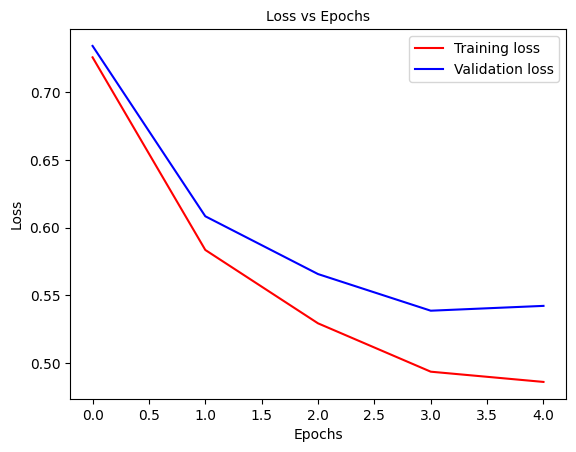

wandb: WARNING Calling wandb.run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


Run num_lay_5 hid_lay_size_32 activ_ReLU wt_init_Xavier Opt_rmsproplrn_rate_0.001


accuracy,▁▅▆█
epoch,▁▃▆█
train_acc,▁▅▇█
train_loss,█▄▂▁
val_acc,▁▅▆█
val_loss,█▃▂▁
accuracy,0.867
epoch,3
train_acc,0.87448
train_loss,0.49346
val_acc,0.867


In [ ]:
wandb.agent(sweep_id,project='CS23M013_DL_A1', function=sweep_for_wandb_, count=1) #Wandb Agent calls

# Question 7 (10 Marks)

For the best model identified above, report the accuracy on the test set of fashion_mnist and plot the confusion matrix as shown below. More marks for creativity (less marks for producing the plot shown below as it is)

Best Model

100%|██████████| 10/10 [03:52<00:00, 23.23s/it]


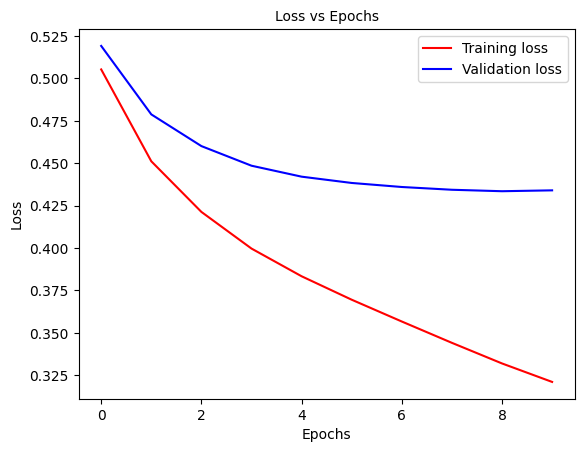

In [ ]:
#First best model identified above
first_best_optimal_model=optimizers_wandb(X_size=784,Y_size=10,num_layers=3,hidden_size=128, activation="tanh",weight_init="Xaviern",epsilon=1e-10 ,
optimizer="nadam",weight_decay=0.001,beta=0.5 , beta1=0.5 , beta2=0.5,batch_size=16,epochs=10,eta=1e-3,ES=False,loss='cross_entropy',log=False)
first_best_optimal_model.run((Xtrain,ytrain),(Xval,yval))

In [ ]:
first_best_optimal_model.train_acc[-1]

0.9166481481481481

In [ ]:
first_y_test_prediction=first_best_optimal_model.neural_Nnetwork_dl.predict(Xtest,True)

In [ ]:
first_best_optimal_model.evaluating_accuracy(ytest,first_y_test_prediction) #accuracy for First Best model

0.8819

In [ ]:
def onehot_reverse(y_prediction):
    return np.argmax(y_prediction, axis=0)

wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg id when running a sweep.


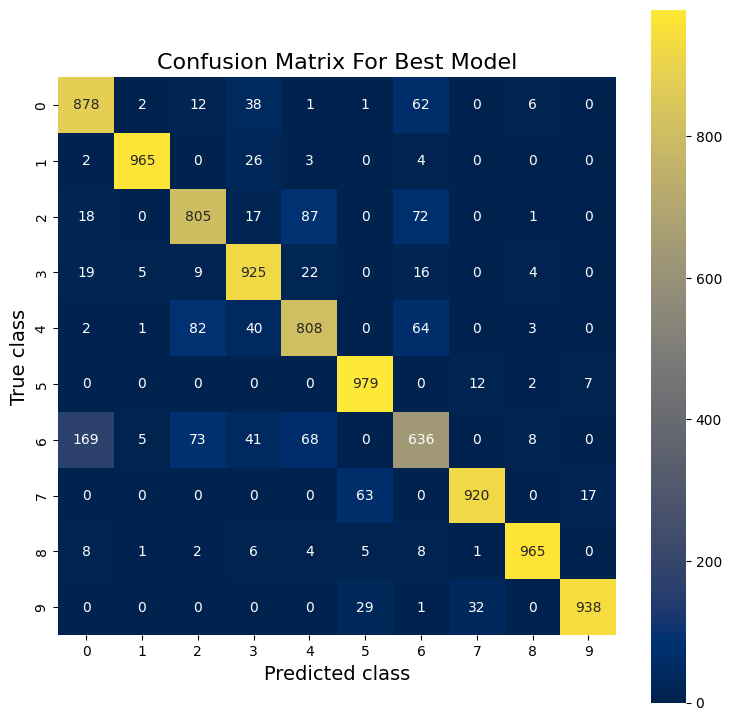

In [ ]:
    y_transposed = onehot_reverse(ytest)
    confuse = np.zeros((10, 10), dtype=np.int16)
    i = 0

    y_pred = onehot_reverse(first_y_test_prediction)
    class_labels={0:'0',1:'1',2:'2',3:'3',4:'4',
                  5:'5',6:'6',7:'7',8:'8',9:'9'}
    while i < len(y_transposed):
      confuse[y_transposed[i], y_pred[i]] += 1
      i += 1

    fig, ax = plt.subplots(figsize=(9, 9))
    sns.heatmap(confuse, annot=True, cmap='cividis', fmt='g', ax=ax, cbar=True, square=True)
    _xlabel='Predicted class'
    ax.set_xlabel(_xlabel, size=14)
    _ylabel='True class'
    ax.set_ylabel(_ylabel, size=14)
    _title='Confusion Matrix For Best Model'
    ax.set_title(_title, size=16)

    wandb.init(project="CS23M013_DL_A1", id="Question 7")
    images = wandb.Image(plt)
    wandb.log({"confusion_matrix": images})
    wandb.run.finish()